# Prep

This blocks installs all the neccesary dependancies, and imports the relevant files

* import tf.models
* install relevant packages 
* import standard dataset
* import additional dataset
* define helper functions


In [ ]:
!pip -q install tf_slim
!pip -q install pycocotools

     |████████████████████████████████| 358kB 7.4MB/s 


In [ ]:
# Import tensorflow.models into the current directory
import os 
import pathlib
import sys

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('...')
elif not pathlib.Path('models').exists():
  print('Downloading from github ... ')
  !git clone --depth 1 https://github.com/tensorflow/models

os.environ['PYTHONPATH'] += ":/content/models"
sys.path.append("/content/models")

Cloning into 'models'...
remote: Enumerating objects: 2017, done.
remote: Counting objects: 100% (2017/2017), done.
remote: Compressing objects: 100% (1755/1755), done.
remote: Total 2017 (delta 459), reused 882 (delta 239), pack-reused 0
Receiving objects: 100% (2017/2017), 30.20 MiB | 4.30 MiB/s, done.
Resolving deltas: 100% (459/459), done.


In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [ ]:
%%bash 
cd models/research
pip -q install .

In [ ]:
# Download data from drive into cwd

if 'Data' not in os.listdir():
  !cp "/content/drive/My Drive/ML/waste_detection/Data/med_res.zip" .
  !unzip -q med_res.zip -d Data
  # Remove the zip file 
  !rm med_res.zip

In [ ]:
if 'extra_furnitures' not in os.listdir():
  !cp "/content/drive/My Drive/ML/waste_detection/Data/extra_furnitures.zip" .
  !unzip -q extra_furnitures.zip -d extra_furnitures
  !rm extra_furnitures.zip

In [ ]:
if 'extra_mattresses' not in os.listdir():
  !cp "/content/drive/My Drive/ML/waste_detection/Data/extra_mattresses.zip" .
  !unzip -q extra_mattresses.zip -d extra_mattresses
  !rm extra_mattresses.zip

if 'extra_various' not in os.listdir():
  !cp "/content/drive/My Drive/ML/waste_detection/Data/extra_various.zip" .
  !unzip -q extra_various.zip -d extra_various
  !rm extra_various.zip

if 'extra_WEEE' not in os.listdir():
  !cp "/content/drive/My Drive/ML/waste_detection/Data/extra_WEEE.zip" .
  !unzip -q extra_WEEE.zip -d extra_WEEE
  !rm extra_WEEE.zip

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import shutil
import json
import random
import re
import io
import imageio
import cv2
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline


In [ ]:
# Helper functions 
from tqdm import tqdm 

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load images into numpy arrays 
def image_to_np(dir, w, h):
  output = [None] * len(os.listdir(dir))
  i = 0
  for file in tqdm(os.listdir(dir)):
    img = load_image_into_numpy_array(dir + file)
    res = cv2.resize(img, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
    output[i] = res
    i += 1
  return output

# Utilizes the visualization_utils
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    threshold = 0.8):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=threshold)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)
  
def split_data(SOURCE, TRAIN_DIR, TEST_DIR, SPLIT_PERCENT, seed = False, FILENAMES=None):

  # Get a list of image names

  if FILENAMES == None:
    files = []
    for filename in os.listdir(SOURCE):
        filepath = SOURCE + filename
        if filepath.endswith('.jpg'):
            files.append(filename)
  else:
    files = FILENAMES

  # Define test and train length
  train_length = int(len(files) * SPLIT_PERCENT)
  test_length = int(len(files)-train_length)

  # Shuffle and split
  # if seed:
  random.seed(1)
  random.shuffle(files)
  training_set = files[0:train_length]
  testing_set = files[-test_length:]

  # move the files
  for filename in training_set:
      os.replace(SOURCE+filename, TRAIN_DIR + filename)
      # shutil.copyfile(SOURCE+filename, TRAIN_DIR+filename)
  for filename in testing_set:
      os.replace(SOURCE+filename, TEST_DIR + filename)
      # shutil.copyfile(SOURCE+filename, TEST_DIR+filename)


# Move
This block moves the images in place and stores the data in memory

* split images into train and test folders
* all json files are stored in the same folder
* normalize boxes
* store all images as numpy arrays into memory
* convert np arrays into tensors, to be passed into model

In [ ]:
# Split data into train and test folders

def extract(label, category):
  # remove this when label is fixed
  # if category not in label:
  #   if category == 'gas_bottles_or_cylinders':
  #     print('found typo')
  #     category = 'gas_bottles_or_cyclinders'
  if label[category] is not None:
    return np.array(label[category])

current_dir = os.getcwd()
image_path = os.path.join(current_dir, 'Data/images')
label_path = os.path.join(current_dir, 'Data/bboxes')

label_names = {1: 'black_bag_waste', 
               2: 'tyres',
               3: 'mattresses',
               4: 'furniture_or_household',
               5: 'gas_bottles_or_cylinders',
               6: 'fire_extinguishers',
               7: 'WEEE'}

valid_jpgs = []

# Select only samples that contain classes from above:
for filepath in os.listdir(image_path):
  filename = filepath.split('/')[-1]
  if filename.endswith('.jpg'):
    json_file = os.path.join(label_path, filename[:-4]+'_bboxs.json')
    with open(json_file, 'r') as file:
      annotation = json.load(file)
      filtered_annotation = np.array([extract(annotation, label_names[i]) for i in label_names])
      for Class in filtered_annotation:
        # Only append if not empty
        if Class is not None:
          valid_jpgs.append(filename)
          break
        # print(annotation[Class])

print(len(os.listdir(image_path)))
print(len(valid_jpgs))

try: 
  os.mkdir(image_path + '/train')
  os.mkdir(image_path + '/test')
  print('Created train and test directories')
except:
  pass

train_dir = os.path.join(image_path, 'train/')
test_dir = os.path.join(image_path, 'test/')

# Execute moving files
try:
  split_data(image_path+'/', train_dir, test_dir, 0.85, seed=True, FILENAMES = valid_jpgs)
except OSError:
  print('error raised')
  pass

print('train folder: {}, test folder: {}'.format(len(os.listdir(train_dir)), len(os.listdir(test_dir))))

223
214
Created train and test directories
train folder: 181, test folder: 33


In [ ]:
pathlist = ['extra_furnitures/', 
            'extra_mattresses/',
            'extra_various/',
            'extra_WEEE/']


for extra_path in pathlist:
  extra_image_path = extra_path + 'images/'
  extra_bbox_path = extra_path + 'bboxes/'
  for filepath in os.listdir(extra_image_path):
    filename = filepath.split('/')[-1]
    # print(filename)
    if filename.endswith('.jpg'):
      annotation_file = filename[:-4] + '_bboxs.json'
      if annotation_file in os.listdir(extra_bbox_path):
        with open(extra_bbox_path+annotation_file, 'r') as file:
          annotation = json.load(file)
          filtered_annotation = np.array([extract(annotation, label_names[i]) for i in label_names])
          for Class in filtered_annotation:
            # Only append if not empty
            if Class is not None:
              os.replace(extra_image_path+filename, 'Data/images/train/' + filename)
              os.replace(extra_bbox_path+annotation_file, 'Data/bboxes/' + annotation_file)
              break
        # print(annotation_file)
        
# for filename in training_set';/.,m:

print('train folder: {}, test folder: {}'.format(len(os.listdir(train_dir)), len(os.listdir(test_dir))))
# print(f'total images: {len(os.listdir('Data/bboxes'))}')

train folder: 312, test folder: 33


In [1]:
# Load label json files into numpy arrays 

def json_to_np(dir):
  output_boxes = []
  output_classes = []
  for i, file in enumerate(os.listdir(dir)):
  #     # Get name of the file
      label_file = os.path.join(label_path, file[:-4]+'_bboxs.json')
      with open(label_file, 'r') as file:
        label = json.load(file)

      categories = np.array([extract(label, label_names[i]) for i in label_names])

      boxes = np.array([[0, 0, 0, 0]])
      classes = np.array([])

      for index, category in enumerate(categories):
        if category is not None:
          boxes = np.vstack([boxes, category])
          classes = np.append(classes, np.array([int(index+1)]*len(category)))
    
      output_boxes.append(boxes[1:].astype('float'))
      output_classes.append(classes.astype('int32'))

  return output_boxes, output_classes

y_train_boxes, y_train_classes = json_to_np(train_dir)
y_test_boxes, y_test_classes = json_to_np(test_dir)

NameError: ignored

In [ ]:
y_test_boxes[1]

array([[0.61596958, 0.12083333, 0.71007605, 0.26025641],
       [0.68845057, 0.23525641, 0.80655894, 0.34070513],
       [0.65993346, 0.30961538, 0.74239544, 0.43621795],
       [0.64353612, 0.47884615, 0.8269962 , 0.68237179],
       [0.0960076 , 0.46185897, 0.30156844, 0.73044872],
       [0.80442015, 0.41730769, 0.95342205, 0.56185897],
       [0.00261407, 0.04262821, 0.14401141, 0.19230769]])

In [ ]:
# Normalize the labels 

# width: 420, height: 312
# Data format right now: [xmin, ymin, xmax, ymax]
# Target format         : [ymin, xmin, ymax, xmax]

orig_width = 640
orig_height = 640

target_width = orig_width
target_height = orig_height

def normalize_boxes(labels, width, height):
  for label in labels:
    for box in label:
      # box[0] /= width
      # box[2] /= width
      # box[1] /= height
      # box[3] /= height

      box[0], box[1], box[2], box[3] = box[1], box[0], box[3], box[2]
  return labels

y_train_boxes = normalize_boxes(y_train_boxes, orig_width, orig_height)
y_test_boxes = normalize_boxes(y_test_boxes, orig_width, orig_height)

print(y_test_boxes[1])

[[0.12083333 0.61596958 0.26025641 0.71007605]
 [0.23525641 0.68845057 0.34070513 0.80655894]
 [0.30961538 0.65993346 0.43621795 0.74239544]
 [0.47884615 0.64353612 0.68237179 0.8269962 ]
 [0.46185897 0.0960076  0.73044872 0.30156844]
 [0.41730769 0.80442015 0.56185897 0.95342205]
 [0.04262821 0.00261407 0.19230769 0.14401141]]


In [ ]:
x_train_np = image_to_np(train_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_train_np)} training images')

x_test_np = image_to_np(test_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_test_np)} training images')

# before: 92s

  0%|          | 0/33 [00:00<?, ?it/s]


 Appended and resized 312 training images


100%|██████████| 33/33 [00:13<00:00,  2.48it/s]


 Appended and resized 33 training images


In [ ]:
# Prepping data, converting np arrays into tensors 
# Note: this needs to be updated for multi-class

def np_to_tensors(image_nps, box_nps, class_nps):
  image_tensors = []
  box_tensors = []
  classes_one_hot_tensors = []

  for (image_np, box_np, class_np) in zip(image_nps, box_nps, class_nps):
    image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        image_np, dtype=tf.float32), axis=0))
    box_tensors.append(tf.convert_to_tensor(box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(class_np - label_id_offset, dtype=np.int32)
    classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

  return image_tensors, box_tensors, classes_one_hot_tensors

binbag_class_id = 1
tyre_class_id = 2
matt_class_id = 3
fur_class_id = 4
gas_class_id = 5
fire_class_id = 6
WEEE_class_id = 7

num_classes = 7

category_index = {}
for i in label_names:
  category_index[i] = {'id': i, 'name': label_names[i]}

label_id_offset = 1

train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors = np_to_tensors(x_train_np, y_train_boxes, y_train_classes)
test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors = np_to_tensors(x_test_np, y_test_boxes, y_test_classes)

print('Done prepping data.')

Done prepping data.


In [ ]:
# plt.rcParams['figure.figsize'] = [14, 7]

# # temp_img_tensors = tf.math.scalar_mul(1/255, train_image_tensors[0])

# bright_image = tf.image.random_brightness(train_image_tensors[0], 0.2)

# # hue_image = tf.image.random_hue(train_image_tensors[0][0], 0.2)
# hue_image = tf.image.random_hue(bright_image, 0.1)

# contrast_image = tf.image.random_contrast(hue_image, 0.8, 1.2)

# plt.subplot(1, 4, 1)
# plt.imshow(train_image_tensors[0][0].numpy())

# plt.subplot(1, 4, 2)
# plt.imshow(bright_image[0].numpy())

# plt.subplot(1, 4, 3)
# plt.imshow(contrast_image[0].numpy())

# plt.subplot(1, 4, 4)
# plt.imshow(hue_image[0].numpy())

In [ ]:
# train_image_tensors[0][0]

In [ ]:
# Optional: visulize images
from skimage.transform import resize

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

plt.figure(figsize=(30, 15))
for i in range(6):
  offset = 6
  plt.subplot(2, 3, i+1)
  plot_detections(
      cv2.resize(x_test_np[i+ offset], dsize=(421, 320), interpolation=cv2.INTER_CUBIC),
      y_test_boxes[i+ offset],
      y_test_classes[i+ offset],
      np.ones(shape=[y_test_boxes[i+ offset].shape[0]], dtype=np.float16),
      category_index)
plt.axis('off')

plt.show()



# Load Config

This block creates the model metaArch, and loads untrained weights

* download weights from tensorflow.models
* loads the config file from '/models/research/object_detection/configs'
* restores weights and create a checkpoint instance



In [ ]:
if 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8' not in os.listdir():
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz 
  !tar -xf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
  !rm ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
# !mv ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-08-28 09:03:03--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.206.128, 2a00:1450:400c:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.206.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M  19.5MB/s    in 1.0s    

2020-08-28 09:03:05 (19.5 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]



In [ ]:
# Configuring and creating the detection model (weight's are not loaded here)

num_classes = 7
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config'
checkpoint_path = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt'

raw_checkpoint = checkpoint_path + '-0'

# Load pipeline config and build a detection model architecture (only need to be ran once)

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
    model_config = model_config, is_training=True
)


In [ ]:
# [i.name for i in detection_model.trainable_variables]
# len(detection_model.trainable_variables)

In [ ]:
# Restore weights (original weights)

def restore_weights(ckpt_path, restore_all=True):

  print(f'restoring weights from {str(ckpt_path)}')

  if restore_all:
    ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
    ckpt.restore(ckpt_path).expect_partial()
  
  else:
    fake_box_predictor = tf.compat.v2.train.Checkpoint(
      _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
      _box_prediction_head=detection_model._box_predictor._box_prediction_head
      )

    fake_model = tf.compat.v2.train.Checkpoint(
                _feature_extractor=detection_model._feature_extractor,
                _box_predictor=fake_box_predictor)
  
    ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
    ckpt.restore(ckpt_path).expect_partial()

  # Run model through a dummy image so that variables are created
  image, shapes = detection_model.preprocess(tf.zeros([1, target_height, target_width, 3]))
  prediction_dict = detection_model.predict(image, shapes)
  _ = detection_model.postprocess(prediction_dict, shapes)
  print('Weights restored!')

  return ckpt

# Initialize ckpt
ckpt = restore_weights(raw_checkpoint, restore_all=False)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0
Weights restored!


# Functions
This block contains the following functions:

* step function (for both training and evaluating)
* layer extraction function
* main training block (given hyperparameters)

### get_model_train_step_function()


In [ ]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list,
                    backprop = True):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(len(image_tensors) * [[target_height, target_width, 3]], dtype=tf.int32)

    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)

    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)

      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

      if backprop:
        gradients = tape.gradient(total_loss, vars_to_fine_tune)
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

    return total_loss

  return train_step_fn

### get_variables()


In [ ]:
def get_variables(prefixes_to_train):
  trainable_variables = detection_model.trainable_variables
  to_fine_tune = []
  for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
      to_fine_tune.append(var)
  return to_fine_tune

  # prefixes_to_train = [
  # 'WeightSharedConvolutionalBoxPredictor']
  # prefixes_to_train = [
  #   'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  #   'WeightSConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']

### train()

In [ ]:
# Flip box
def flip_box_left_right(boxes):
  tempboxes = boxes.numpy()
  for i in range(len(tempboxes)):
    tempboxes[i][1], tempboxes[i][3] = 1 - tempboxes[i][3], 1 - tempboxes[i][1]
    # tempboxes[i][3] = 1 - tempboxes[i][1]
  
  return tf.convert_to_tensor(tempboxes, dtype=tf.float32)

In [ ]:
def train(epochs, 
          batch_size, 
          train_step_fn, 
          flip_ratio = 0.2,
          color_alter_ratio = 0.1):
  '''
    Performs training given epoch and batch size 

    Note: this function does not generalize, neither x_train_np or labels are passed
    as arguments
  '''

  # tf.keras.backend.set_learning_phase(True)

  num_batches = (len(x_train_np) // batch_size)

  print('Started fine-tuning!', flush=True)
  for e in range(epochs):

    epoch_loss = 0

    all_keys = list(range(len(x_train_np)))
    random.shuffle(all_keys)

    cv_loss = test_evaluate()

    for i in tqdm(range(num_batches)):

      # Grab keys for a random subset of examples
      example_keys = all_keys[(i*batch_size):((i+1)*batch_size)]
      # grab x and y using keys 
      gt_boxes_list, gt_classes_list, image_tensors = [], [], []
      for key in example_keys:
        temp_image = train_image_tensors[key]
        temp_box = gt_box_tensors[key]
        if random.random() < flip_ratio:
          # image_tensors.append(tf.image.flip_left_right(train_image_tensors[key]))
          # gt_boxes_list.append(flip_box_left_right(gt_box_tensors[key]))
          temp_image = tf.image.flip_left_right(temp_image)
          temp_box = flip_box_left_right(temp_box)
        # if random.random() < color_alter_ratio:
        #   temp_image = tf.image.random_contrast(
        #       tf.image.random_hue(
        #           tf.image.random_brightness(temp_image, 0.2), 0.1), 0.8, 1.2)
        # else:
        #   image_tensors.append(train_image_tensors[key])
        #   gt_boxes_list.append(gt_box_tensors[key])
        image_tensors.append(temp_image)
        gt_boxes_list.append(temp_box)
        gt_classes_list.append(gt_classes_one_hot_tensors[key])

      # gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
      # gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
      # image_tensors = [train_image_tensors[key] for key in example_keys]

      # Training step (forward pass + backwards pass)
      total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
      epoch_loss += total_loss.numpy()

    epoch_loss /= num_batches
    
    print(f'epoch {e+1} of {epochs}, loss= {epoch_loss}, cv_loss = {cv_loss}')
  
  cv_loss = test_evaluate()

  print(f'final cv_loss: {cv_loss}')
  print('Done fine-tuning!')

### test_evaluate()

In [ ]:
def test_evaluate():
  batch_size = 5
  loss = 0
  num_batches = len(test_image_tensors) // batch_size
  # train_step_fn(test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors, backprop=False)

  keys = list(range(len(x_test_np)))

  for i in range(num_batches):
    key_batch = keys[(i*batch_size):((i+1)*batch_size)]
    gt_boxes_list, gt_classes_list, image_tensors = [], [], []

    for key in key_batch:
      image_tensors.append(test_image_tensors[key])
      gt_boxes_list.append(test_gt_box_tensors[key])
      gt_classes_list.append(test_gt_classes_one_hot_tensors[key])

    loss += train_step_fn(image_tensors, gt_boxes_list, gt_classes_list, backprop=False)
  
  return loss.numpy()/num_batches

# Training Block

This block contains: 
* Training Top
* Training Middle
* Training Whole
* Save trained Model


## Save untuned


In [ ]:
untuned_checkpoint = ckpt.save(checkpoint_path+'-untuned') 
# untuned_checkpoint = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-untuned-52'

In [ ]:
# Optional - load
ckpt = restore_weights(untuned_checkpoint, restore_all = True)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-untuned-52
Weights restored!


## Top


### Hyperparameters


In [ ]:
# SELECT THE TOP LAYERS, and set up the training
tf.keras.backend.clear_session()

# Restore weights
# ckpt = restore_weights(raw_checkpoint, restore_all=False)
# try: 
#   ckpt = restore_weights(untuned_checkpoint, restore_all = True)
# except:
#   print('could not restore untuned weights')
#   pass

# Hyper parameters
epochs = 98
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# Define Optimizer
optimizer = tf.keras.optimizers.Adam()

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
                              'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# Run on CV:
test_loss = test_evaluate()
print(test_loss)

# Untuned - 1.45610507329305

1.0353347460428874


### Train

In [ ]:
train(epochs, batch_size, train_step_fn, flip_ratio = 0.3, color_alter_ratio = 0.2)

Started fine-tuning!


100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


epoch 1 of 98, loss= 0.9675797262499409, cv_loss = 1.0353347460428874


100%|██████████| 62/62 [00:40<00:00,  1.54it/s]


epoch 2 of 98, loss= 0.9309468105916054, cv_loss = 1.004357894261678


100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


epoch 3 of 98, loss= 0.8961257146250817, cv_loss = 0.9831014474232992


100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


epoch 4 of 98, loss= 0.8759300612634228, cv_loss = 0.9695820808410645


100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


epoch 5 of 98, loss= 0.858440060769358, cv_loss = 0.965895414352417


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 6 of 98, loss= 0.8573231043354157, cv_loss = 0.9602264563242594


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 7 of 98, loss= 0.8426228156012874, cv_loss = 0.9531830151875814


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 8 of 98, loss= 0.8384707156688936, cv_loss = 0.9537014961242676


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 9 of 98, loss= 0.8359695134624359, cv_loss = 0.9489896297454834


100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


epoch 10 of 98, loss= 0.8263542296424988, cv_loss = 0.9423589706420898


100%|██████████| 62/62 [00:41<00:00,  1.50it/s]


epoch 11 of 98, loss= 0.8136675338591298, cv_loss = 0.9329806168874105


100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


epoch 12 of 98, loss= 0.8091896801225601, cv_loss = 0.9435877799987793


100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


epoch 13 of 98, loss= 0.8079413733174724, cv_loss = 0.9420483907063802


100%|██████████| 62/62 [00:40<00:00,  1.54it/s]


epoch 14 of 98, loss= 0.7952432324809413, cv_loss = 0.9378155867258707


100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


epoch 15 of 98, loss= 0.8025815957976926, cv_loss = 0.9355041186014811


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 16 of 98, loss= 0.8041288670032255, cv_loss = 0.9366666475931803


100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


epoch 17 of 98, loss= 0.8015451854275119, cv_loss = 0.9277452627817789


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 18 of 98, loss= 0.7952801681333973, cv_loss = 0.9271527131398519


100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


epoch 19 of 98, loss= 0.7915581234039799, cv_loss = 0.9239768187204996


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 20 of 98, loss= 0.7884448209116536, cv_loss = 0.9265182813008627


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 21 of 98, loss= 0.7851286059425723, cv_loss = 0.9230742454528809


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 22 of 98, loss= 0.7939990768509526, cv_loss = 0.9237829049428304


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 23 of 98, loss= 0.7869308451491017, cv_loss = 0.9290350278218588


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 24 of 98, loss= 0.7738713953764208, cv_loss = 0.9228489398956299


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 25 of 98, loss= 0.7831412957560632, cv_loss = 0.9261053403218588


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 26 of 98, loss= 0.77968799587219, cv_loss = 0.9260110855102539


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 27 of 98, loss= 0.7705955293870741, cv_loss = 0.9213081995646158


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 28 of 98, loss= 0.7736863815976728, cv_loss = 0.9243254661560059


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 29 of 98, loss= 0.7783959363737414, cv_loss = 0.9226897557576498


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 30 of 98, loss= 0.7773858231882895, cv_loss = 0.9252337614695231


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 31 of 98, loss= 0.7732918695096047, cv_loss = 0.9269797801971436


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 32 of 98, loss= 0.7800152840152863, cv_loss = 0.9224379857381185


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 33 of 98, loss= 0.7669772236577926, cv_loss = 0.923177162806193


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 34 of 98, loss= 0.7743293816043485, cv_loss = 0.9314135710398356


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 35 of 98, loss= 0.768878270541468, cv_loss = 0.9229718049367269


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 36 of 98, loss= 0.7695605456829071, cv_loss = 0.9143187204996744


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 37 of 98, loss= 0.7711467079577907, cv_loss = 0.9183187484741211


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 38 of 98, loss= 0.7665845963262743, cv_loss = 0.9251972039540609


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 39 of 98, loss= 0.7685875277365407, cv_loss = 0.9213621616363525


100%|██████████| 62/62 [00:41<00:00,  1.49it/s]


epoch 40 of 98, loss= 0.7585640025715674, cv_loss = 0.9197702407836914


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 41 of 98, loss= 0.7678608884734492, cv_loss = 0.9274922211964926


100%|██████████| 62/62 [00:41<00:00,  1.50it/s]


epoch 42 of 98, loss= 0.7617165167485515, cv_loss = 0.9229123592376709


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 43 of 98, loss= 0.7672023157919606, cv_loss = 0.9313014348347982


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 44 of 98, loss= 0.7561911046504974, cv_loss = 0.9234240849812826


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 45 of 98, loss= 0.7614496782902749, cv_loss = 0.9293164412180582


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 46 of 98, loss= 0.7610065268893396, cv_loss = 0.9271322886149088


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 47 of 98, loss= 0.7641482660847325, cv_loss = 0.9275290171305338


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 48 of 98, loss= 0.7607061420717547, cv_loss = 0.925072193145752


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 49 of 98, loss= 0.7638280305170244, cv_loss = 0.9176511764526367


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 50 of 98, loss= 0.7497830737021661, cv_loss = 0.9234886964162191


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 51 of 98, loss= 0.7595278389992253, cv_loss = 0.9204115867614746


100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


epoch 52 of 98, loss= 0.753646892886008, cv_loss = 0.9201664129892985


100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


epoch 53 of 98, loss= 0.7617391266169087, cv_loss = 0.9213254451751709


100%|██████████| 62/62 [00:41<00:00,  1.50it/s]


epoch 54 of 98, loss= 0.7656566212254186, cv_loss = 0.9167164961496989


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 55 of 98, loss= 0.7590286251037351, cv_loss = 0.9232943058013916


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 56 of 98, loss= 0.7465579423212236, cv_loss = 0.922659158706665


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 57 of 98, loss= 0.7548629905908338, cv_loss = 0.9216499328613281


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 58 of 98, loss= 0.7537987212980947, cv_loss = 0.9180335203806559


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 59 of 98, loss= 0.7572745402013102, cv_loss = 0.9158722559611002


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 60 of 98, loss= 0.7484091645286929, cv_loss = 0.9148360093434652


100%|██████████| 62/62 [00:41<00:00,  1.50it/s]


epoch 61 of 98, loss= 0.7541552089875744, cv_loss = 0.9223702748616537


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 62 of 98, loss= 0.7514236780904955, cv_loss = 0.9193131923675537


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 63 of 98, loss= 0.7528331058640634, cv_loss = 0.9168399969736735


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 64 of 98, loss= 0.762036346620129, cv_loss = 0.9205323855082194


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 65 of 98, loss= 0.7519273373388475, cv_loss = 0.9236161708831787


100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


epoch 66 of 98, loss= 0.7598751062347043, cv_loss = 0.9215194384256998


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 67 of 98, loss= 0.7532564829434117, cv_loss = 0.9186827341715494


100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


epoch 68 of 98, loss= 0.7507397542076726, cv_loss = 0.9271078109741211


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 69 of 98, loss= 0.7544677920879856, cv_loss = 0.9210646152496338


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 70 of 98, loss= 0.7578510478619607, cv_loss = 0.9264045556386312


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 71 of 98, loss= 0.7558406197255657, cv_loss = 0.9167465368906657


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 72 of 98, loss= 0.7490330319250783, cv_loss = 0.919565757115682


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 73 of 98, loss= 0.7418984088205522, cv_loss = 0.9279211362202963


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 74 of 98, loss= 0.750762177090491, cv_loss = 0.9187188148498535


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 75 of 98, loss= 0.739578228804373, cv_loss = 0.9206631978352865


100%|██████████| 62/62 [00:41<00:00,  1.50it/s]


epoch 76 of 98, loss= 0.7535307936130031, cv_loss = 0.9196357727050781


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 77 of 98, loss= 0.7481862200844672, cv_loss = 0.9215451081593832


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 78 of 98, loss= 0.7451565438701261, cv_loss = 0.9186646143595377


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 79 of 98, loss= 0.7489508380812984, cv_loss = 0.9220760663350424


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 80 of 98, loss= 0.7412451688320406, cv_loss = 0.920152505238851


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 81 of 98, loss= 0.7362031330985408, cv_loss = 0.9270788828531901


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 82 of 98, loss= 0.7568203181989731, cv_loss = 0.917487382888794


100%|██████████| 62/62 [00:41<00:00,  1.50it/s]


epoch 83 of 98, loss= 0.7515849269205525, cv_loss = 0.9175597826639811


100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


epoch 84 of 98, loss= 0.7422507520644895, cv_loss = 0.9250591595967611


100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


epoch 85 of 98, loss= 0.7371170107395418, cv_loss = 0.9206034342447916


100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


epoch 86 of 98, loss= 0.7430887972154925, cv_loss = 0.9224184354146322


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 87 of 98, loss= 0.7480472480097125, cv_loss = 0.9202168782552084


100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


epoch 88 of 98, loss= 0.7451155291449639, cv_loss = 0.9221022923787435


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 89 of 98, loss= 0.7356867468164813, cv_loss = 0.909486452738444


100%|██████████| 62/62 [00:41<00:00,  1.50it/s]


epoch 90 of 98, loss= 0.7469412424871998, cv_loss = 0.918436606725057


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 91 of 98, loss= 0.7395532188876983, cv_loss = 0.9267424742380778


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 92 of 98, loss= 0.7465738707011745, cv_loss = 0.9170955816904703


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 93 of 98, loss= 0.7478722362749038, cv_loss = 0.9303665161132812


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 94 of 98, loss= 0.7400225737402516, cv_loss = 0.9243535995483398


100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


epoch 95 of 98, loss= 0.7387928876184648, cv_loss = 0.9134414990743002


100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


epoch 96 of 98, loss= 0.7447117884312907, cv_loss = 0.9195356369018555


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 97 of 98, loss= 0.7396078922094838, cv_loss = 0.9202279249827067


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 98 of 98, loss= 0.7434675083045037, cv_loss = 0.9133044083913168
final cv_loss: 0.9220883051554362
Done fine-tuning!


### Save

In [ ]:
top_trained_checkpoint = ckpt.save(checkpoint_path+'-top')
# top_trained_checkpoint = checkpoint_path + '-top_trained-55'
print(top_trained_checkpoint)

ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-top-53


## Mid

In [ ]:
# Restore weights
restore_weights(top_trained_checkpoint, restore_all=True)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-top-53
Weights restored!


### Hyperparameters

In [ ]:
# Select box predictor variables to train

# Hyperparameters
epochs = 10
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# loss = train_step_fn(train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors, backprop=False)
cv_loss = test_evaluate()

# print(loss.numpy())
print(cv_loss)

# top-trained:0.8682906

0.8445513248443604


### Train

In [ ]:
train(epochs, batch_size, train_step_fn, flip_ratio = 0.3, color_alter_ratio=0.2)

Started fine-tuning!


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 1 of 10, loss= 0.6177138147815582, cv_loss = 0.8445513248443604


100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


epoch 2 of 10, loss= 0.6116530972142373, cv_loss = 0.8485990365346273


100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


epoch 3 of 10, loss= 0.6109559204309217, cv_loss = 0.8401479721069336


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 4 of 10, loss= 0.6002896817461136, cv_loss = 0.8358504772186279


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


epoch 5 of 10, loss= 0.6088326703156194, cv_loss = 0.8465487162272135


100%|██████████| 62/62 [00:41<00:00,  1.50it/s]


epoch 6 of 10, loss= 0.6120449891013484, cv_loss = 0.8446815808614095


100%|██████████| 62/62 [00:41<00:00,  1.49it/s]


epoch 7 of 10, loss= 0.5999794977326547, cv_loss = 0.8367547988891602


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 8 of 10, loss= 0.5993386276306645, cv_loss = 0.8401173750559489


100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


epoch 9 of 10, loss= 0.5951261025282645, cv_loss = 0.844068686167399


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 10 of 10, loss= 0.5916698190473741, cv_loss = 0.8484248320261637
final cv_loss: 0.8416042327880859
Done fine-tuning!


### Save

In [ ]:
big_top_path = ckpt.save(checkpoint_path+'-boxPredictor')

## All

In [ ]:
restore_weights(big_top_path, restore_all=True)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-boxPredictor-55
Weights restored!


### Hyperparameters

In [ ]:
# Select all variables to train

# Hyperparameters
epochs = 10
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

# Select variables in top layers to fine-tune.
# to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor'])
to_fine_tune = detection_model.trainable_variables

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# loss = train_step_fn(train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors, backprop=False)
cv_loss = test_evaluate()

# print(loss.numpy())
print(cv_loss)

# big-top-trained: 0.8113712

0.8416042327880859


### Train

In [ ]:
train(epochs, batch_size, train_step_fn, flip_ratio = 0.3, color_alter_ratio=0.2)

Started fine-tuning!


100%|██████████| 62/62 [00:41<00:00,  1.49it/s]


epoch 1 of 10, loss= 0.5963079616908105, cv_loss = 0.8416042327880859


100%|██████████| 62/62 [00:41<00:00,  1.50it/s]


epoch 2 of 10, loss= 0.5537932048882207, cv_loss = 0.8002297083536783


100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


epoch 3 of 10, loss= 0.512191915704358, cv_loss = 0.7946783701578776


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 4 of 10, loss= 0.5017307467998997, cv_loss = 0.7997331619262695


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 5 of 10, loss= 0.48146709415220446, cv_loss = 0.7807151476542155


100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


epoch 6 of 10, loss= 0.458805249102654, cv_loss = 0.779776414235433


100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


epoch 7 of 10, loss= 0.43087598272869665, cv_loss = 0.7737147808074951


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 8 of 10, loss= 0.42108112717828444, cv_loss = 0.7824711004892985


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 9 of 10, loss= 0.4104950519338731, cv_loss = 0.779590368270874


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


epoch 10 of 10, loss= 0.3912558940149123, cv_loss = 0.7812137603759766
final cv_loss: 0.785209576288859
Done fine-tuning!


### Save

In [ ]:
entire_model_path = ckpt.save(checkpoint_path+'-all-trained')

In [ ]:
restore_weights(entire_model_path, restore_all=True)

cv_loss = test_evaluate()

print(cv_loss)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-56
Weights restored!
0.785209576288859


## Optional: export ckpt

In [ ]:
# Create export folder
model_to_export = ckpt.save('export/ckpt')

In [ ]:
# Create zip file
%%bash
cd 'export'
ls
zip -r extra_all_1.zip . -x ".*" -x "__MACOSX"
# cp 'export/seven_classes.zip' '/content/drive/My Drive/ML'

checkpoint
ckpt-57.data-00000-of-00001
ckpt-57.index
  adding: checkpoint (deflated 38%)
  adding: ckpt-57.data-00000-of-00001 (deflated 8%)
  adding: ckpt-57.index (deflated 80%)


In [ ]:
# Copy to drive
!cp 'export/extra_all_1.zip' '/content/drive/My Drive/ML'

# Test


## Optional: Load trained ckpt

In [ ]:
# !cp '/content/drive/My Drive/ML/checkpoints2.zip' .
!cp '/content/drive/My Drive/ML/seven_classes_4.zip' .
!unzip -q seven_classes_4.zip
# Remove the zip file 
!rm seven_classes_4.zip 

replace ckpt-56.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
restore_weights('ckpt-56')

restoring weights from ckpt-56
Weights restored!


## detect()


In [ ]:
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)


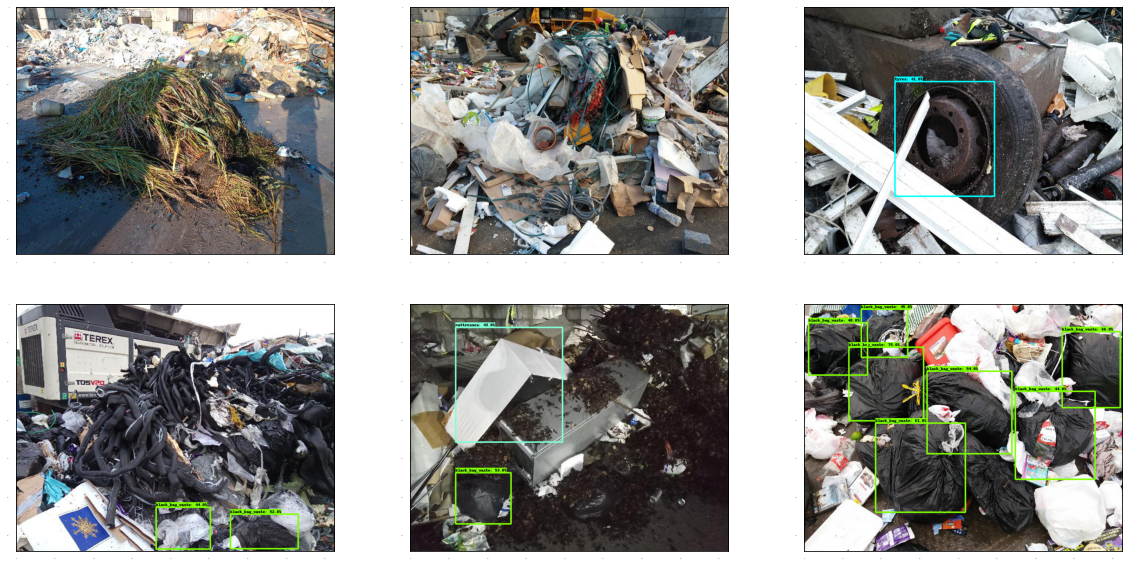

In [ ]:
plt.figure(figsize=(20,10))
for i in range(6):
  offset = 24
  input_tensor = tf.convert_to_tensor(np.expand_dims(x_test_np[i+offset], axis=0), dtype=tf.float32)
  detection = detect(input_tensor)
  plt.subplot(2, 3, i+1)
  plot_detections(
      cv2.resize(x_test_np[i+offset], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.4)
plt.show()



In [ ]:
tempdir = '/content/drive/My Drive/ML/'
!mv tempdir /content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-58.data-00001-of-00002
# !cp /content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-58.data-00001-of-00002 '/content/drive/My Drive/ML/'

mv: cannot stat '/content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-58.data-00001-of-00002': No such file or directory


# mAP

## Detection vs gt

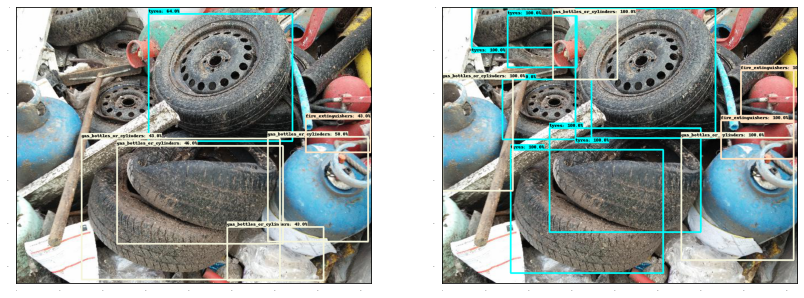

In [ ]:
idx = 31

detection = detect(test_image_tensors[idx])

plt.subplot(1, 2, 1)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.4)

plt.subplot(1, 2, 2)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      y_test_boxes[idx],
      y_test_classes[idx],
      np.ones(shape=[y_test_classes[idx].shape[0]], dtype=np.float16),
      category_index)

## mAP Block

In [ ]:
# Calculate IOU 
  # There is one IOU value per box (in prediction)
  # Match to Ground truth or none

# Ground truth boxes: m x 4 np array 
# Detection boxes: 1 x 100 x 4 tensor 

# [ymin, xmin, ymax, xmax]

# xi1 = maximum of the x1 coordinates of the two boxes
# yi1 = maximum of the y1 coordinates of the two boxes
# xi2 = minimum of the x2 coordinates of the two boxes
# yi2 = minimum of the y2 coordinates of the two boxes

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    # Assign variable names to coordinates for clarity
    (box1_y1, box1_x1, box1_y2, box1_x2) = box1
    (box2_y1, box2_x1, box2_y2, box2_x2) = box2
    
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2
    xi1 = np.maximum(box1_x1, box2_x1)
    yi1 = np.maximum(box1_y1, box2_y1)
    xi2 = np.minimum(box1_x2, box2_x2)
    yi2 = np.minimum(box1_y2, box2_y2)
    inter_width = yi2 - yi1
    inter_height = xi2 - xi1
    if inter_width < 0 or inter_height < 0:
        return 0
    inter_area = inter_width * inter_height

    # Calculate the Union area
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = (box1_area + box2_area) - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    
    return iou

def filter_from_score(scores, classes, boxes, threshold):
  for i, score in enumerate(scores):
    if score < threshold:
      break
  return scores[:i], classes[:i], boxes[:i]

def get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes):

  '''
    boxes: [ymin, xmin, ymax, xmax]
  '''

  ious_arr = []
  detected_which = []
  hash_table = [None] * len(gt_boxes)

  for i, (box, label) in enumerate(zip(detected_boxes, detected_classes)):
    max_iou = 0
    detected_which.append(-1)
    for j, (gt_box, gt_class) in enumerate(zip(gt_boxes, gt_classes)):
      if gt_class == label:
        iou_val = iou(gt_box, box)
        if iou_val > max_iou:
          max_iou = iou_val
          detected_which[i] = j
          if not hash_table[j]:
            hash_table[j] = (max_iou, i)
          else:
            if hash_table[j][0] < max_iou:
              detected_which[hash_table[j][1]] = -1
              hash_table[j] = (max_iou, i)
              
    ious_arr.append(max_iou)

  return ious_arr, detected_which

def get_tpfp(ious_arr, detected_which, iou_threshold = 0.5):

  tpfp = []
  for which, iou_val in zip(detected_which, ious_arr):
    if which < 0 or iou_val < iou_threshold:
      tpfp.append(0)
    else:
      tpfp.append(1) 
  
  return tpfp

def get_tpfp_list(detected_box_list, detected_class_list, detected_score_list, gt_box_list, gt_class_list, iou_threshold):
  '''
    Categorizes detections into a list of true positives and false positives in descending order of confidence level
  '''
  tpfp_list = []

  for idx in range(len(detected_score_list)):
    detected_boxes, detected_classes, detected_scores = detected_box_list[idx], detected_class_list[idx], detected_score_list[idx]

    gt_boxes = gt_box_list[idx]
    gt_classes = gt_class_list[idx]

    ious_arr, detected_which = get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes)

    tpfp = get_tpfp(ious_arr, detected_which, iou_threshold=iou_threshold)

    tpfp_score_pairs = [(i, j) for i, j in zip(tpfp, detected_scores)]

    tpfp_list += tpfp_score_pairs
  
  return tpfp_list

def calculate_map(detected_box_list, 
                  detected_class_list, 
                  detected_score_list, 
                  gt_box_list, 
                  gt_class_list, 
                  num_of_classes,
                  iou_threshold = 0.5):
  '''
    calculates mAP, outputs precision and recall

    Inputs are filtered lists of detection boxes, classes, and confidence scores
    Detections have to be preprocessed and filtered based on confidence threshold

    detected_box_list: m x ? x 4
    detected_class_list: m x ?
    detected_score_list: m x ?

    gt_box_list: m x ?
    gt_class_list: m x ?

    where m is the number of samples
    ? because the number of detections and number of gt boxes is different for each sample
    all lists are lists of np arrays
  '''

  precision_list = []
  recall_list = []
  map_list = []

  for c in range(num_of_classes):
    class_eval = c + 1

    length = len(detected_box_list)
    detected_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    detected_classes_eval = [np.array([])]*length
    detected_scores_eval = [np.array([])]*length

    length = len(gt_class_list)
    gt_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    gt_classes_eval = [np.array([])]*length


    for i, detected_class in enumerate(detected_class_list):
      for j, Class in enumerate(detected_class):
        if Class == class_eval:
          detected_classes_eval[i] = np.append(detected_classes_eval[i], detected_class_list[i][j])
          detected_boxes_eval[i] = np.vstack([detected_boxes_eval[i], detected_box_list[i][j]])
          detected_scores_eval[i] = np.append(detected_scores_eval[i], detected_score_list[i][j])
      if detected_boxes_eval[i].shape[0] == 1:
        detected_boxes_eval[i] = np.array([])
      else:
        detected_boxes_eval[i] = detected_boxes_eval[i][1:]

    for i, gt_class in enumerate(gt_class_list):
      for j, Class in enumerate(gt_class):
        if Class == class_eval:
          gt_classes_eval[i] = np.append(gt_classes_eval[i], gt_class_list[i][j])
          gt_boxes_eval[i] = np.vstack([gt_boxes_eval[i], gt_box_list[i][j]])
      if gt_boxes_eval[i].shape[0] == 1:
        gt_boxes_eval[i] = np.array([])
      else:
        gt_boxes_eval[i] = gt_boxes_eval[i][1:]

    tpfp_list = get_tpfp_list(detected_boxes_eval, 
                              detected_classes_eval, 
                              detected_scores_eval, 
                              gt_boxes_eval, 
                              gt_classes_eval, 
                              iou_threshold=iou_threshold)
                              

    tpfp_list.sort(key=lambda tup: tup[1], reverse=True)

    precisions = []
    recalls = []
    tp = 0
    fp = 0

    total = 0
    for i in gt_boxes_eval:
      total += len(i)

    detection_total = 0
    for i in detected_boxes_eval:
      detection_total += len(i)

    for i, (tpfp, _) in enumerate(tpfp_list):
      if tpfp == 1:
        tp += 1
      else:
        fp += 1

      precision = tp/(tp+fp)
      if total > 0:
        recall = tp/total
      else:
        recall = 0

      precisions.append(precision)
      recalls.append(recall)

    print(f'{label_names[c+1]}: {total} annotations')
    print(f'{tp} / {detection_total} correct detections \n')
    map = np.trapz(precisions, recalls)
    precision_list.append(np.array(precisions))
    recall_list.append(np.array(recalls))
    map_list.append(map)

  return precision_list, recall_list, map_list

## mAP - Train

In [ ]:
detected_boxes = []
detected_classes = []
detected_scores = []

for i in tqdm(range(len(y_train_classes))):
  detection = detect(train_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+label_id_offset,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.4)
  detected_boxes.append(detected_box)
  detected_classes.append(detected_class)
  detected_scores.append(detected_score)


In [ ]:
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_train_boxes, 
                          y_train_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5)

print(map)
sum(map)/num_classes



black_bag_waste: 483 annotations
293 / 384 correct detections 

tyres: 131 annotations
83 / 116 correct detections 

mattresses: 99 annotations
85 / 108 correct detections 

furniture_or_household: 337 annotations
212 / 294 correct detections 

gas_bottles_or_cylinders: 82 annotations
61 / 113 correct detections 

fire_extinguishers: 57 annotations
38 / 71 correct detections 

WEEE: 94 annotations
62 / 77 correct detections 

[0.5014578765673467, 0.42666402921123064, 0.7296299766962828, 0.524232821191369, 0.3672415838683978, 0.3827313638224998, 0.5317419782946511]


0.49481423280739684

## mAP - Test

In [ ]:
detected_boxes = []
detected_classes = []
detected_scores = []

for i in range(len(y_test_classes)):
  detection = detect(test_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+label_id_offset,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.3)
  detected_boxes.append(detected_box)
  detected_classes.append(detected_class)
  detected_scores.append(detected_score)


In [ ]:
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_test_boxes, 
                          y_test_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5)

print(map)
sum(map)/7

black_bag_waste: 91 annotations
38 / 99 correct detections 

tyres: 9 annotations
5 / 12 correct detections 

mattresses: 2 annotations
0 / 3 correct detections 

furniture_or_household: 16 annotations
6 / 30 correct detections 

gas_bottles_or_cylinders: 7 annotations
2 / 7 correct detections 

fire_extinguishers: 2 annotations
0 / 3 correct detections 

WEEE: 5 annotations
1 / 5 correct detections 

[0.2308131675542008, 0.19030784030784031, 0.0, 0.09960062324371535, 0.03231292517006802, 0.0, 0.0]


0.07900493661083206